#**1. Tải bộ dữ liệu:**

In [20]:
!gdown --id 1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639
!unzip img_cls_scenes_classification.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: scenes_classification/train/mountain/16114.jpg  
  inflating: scenes_classification/train/mountain/16150.jpg  
  inflating: scenes_classification/train/mountain/16162.jpg  
  inflating: scenes_classification/train/mountain/16173.jpg  
  inflating: scenes_classification/train/mountain/16225.jpg  
  inflating: scenes_classification/train/mountain/16322.jpg  
  inflating: scenes_classification/train/mountain/16341.jpg  
  inflating: scenes_classification/train/mountain/16350.jpg  
  inflating: scenes_classification/train/mountain/16374.jpg  
  inflating: scenes_classification/train/mountain/16375.jpg  
  inflating: scenes_classification/train/mountain/16417.jpg  
  inflating: scenes_classification/train/mountain/1642.jpg  
  inflating: scenes_classification/train/mountain/16421.jpg  
  inflating: scenes_classification/train/mountain/16438.jpg  
  inflating: scenes_classification/train/mountain/16560.jpg  
  inflating: s

#2. Import các thư viện cần thiết:**

In [21]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

#**3. Cố định giá trị ngẫu nhiên:**

In [22]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

#**4. Đọc dữ liệu:**

In [23]:
root_dir = '/content/scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(train_dir))
        )
}

X_train, y_train, X_test, y_test = [], [], [], []
for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

#**5. Chia bộ dữ liệu train, val, test:**

In [24]:
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

#**6. Xây dựng class pytorch datasets:**

In [25]:
class ScenesDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

#**7. Xây dựng hàm tiền xử lý ảnh (transform):**

In [26]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float() # move channel to the front
    normalized_img = img / 255.0

    return normalized_img

#**8. Khai báo datasets object cho ba bộ train, val, test:**

In [27]:
train_dataset = ScenesDataset(X_train, y_train, transform=transform)
val_dataset = ScenesDataset(X_val, y_val, transform=transform)
test_dataset = ScenesDataset(X_test, y_test, transform=transform)

#**9. Khai báo dataloader:**

In [28]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

torch.Size([64, 3, 224, 224])
torch.Size([64])


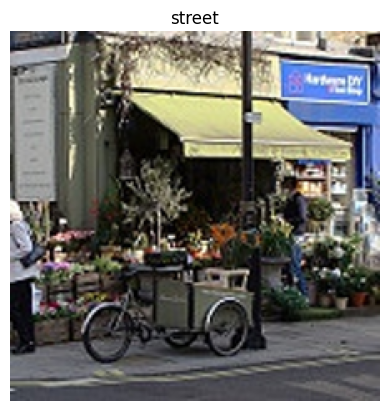

In [29]:
img_samples, label_samples = next(iter(train_loader))
print(img_samples.shape)
print(label_samples.shape)

img_sample = img_samples[0]
plt.imshow(img_sample.permute(1, 2, 0))
plt.title(classes[label_samples[0].item()])
plt.axis('off')
plt.show()

#**10. Xây dựng model:**


In [30]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x.clone().detach()
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = torch.cat([res, out], dim=1)

        return out

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [31]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        # Transition layers
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                ))
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool1(out)

        for block in self.dense_blocks:
            out = block(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.pool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [32]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DenseNet(
    [6, 12, 24, 16],
    growth_rate=32,
    num_classes=n_classes
).to(device)

In [33]:
model.eval()
dummy_tensor = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(dummy_tensor)
print('Output shape:', output.shape)

Output shape: torch.Size([1, 6])


# **11. Xây dựng hàm đánh giá model:**

In [34]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

#**12. Xây dựng hàm huấn luyện model:**

In [35]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

#**11. Khai báo hàm loss và thuật toán huấn luyện:**

In [36]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

#**12. Thực hiện huấn luyện:**

In [39]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH 1:	Train loss: 1.0639	Val loss: 1.0373
EPOCH 2:	Train loss: 1.0122	Val loss: 0.9941
EPOCH 3:	Train loss: 0.9625	Val loss: 0.9479
EPOCH 4:	Train loss: 0.9209	Val loss: 0.9078
EPOCH 5:	Train loss: 0.8796	Val loss: 0.8712
EPOCH 6:	Train loss: 0.8449	Val loss: 0.8446
EPOCH 7:	Train loss: 0.8131	Val loss: 0.8331
EPOCH 8:	Train loss: 0.7846	Val loss: 0.7877
EPOCH 9:	Train loss: 0.7521	Val loss: 0.7800
EPOCH 10:	Train loss: 0.7269	Val loss: 0.7482
EPOCH 11:	Train loss: 0.6980	Val loss: 0.7397
EPOCH 12:	Train loss: 0.6722	Val loss: 0.7227
EPOCH 13:	Train loss: 0.6470	Val loss: 0.6941
EPOCH 14:	Train loss: 0.6258	Val loss: 0.6560
EPOCH 15:	Train loss: 0.5921	Val loss: 0.6731
EPOCH 16:	Train loss: 0.5724	Val loss: 0.6371
EPOCH 17:	Train loss: 0.5452	Val loss: 0.7418
EPOCH 18:	Train loss: 0.5205	Val loss: 0.6186
EPOCH 19:	Train loss: 0.4958	Val loss: 0.6552
EPOCH 20:	Train loss: 0.4807	Val loss: 0.6107
EPOCH 21:	Train loss: 0.4562	Val loss: 0.5837
EPOCH 22:	Train loss: 0.4407	Val loss: 0.75

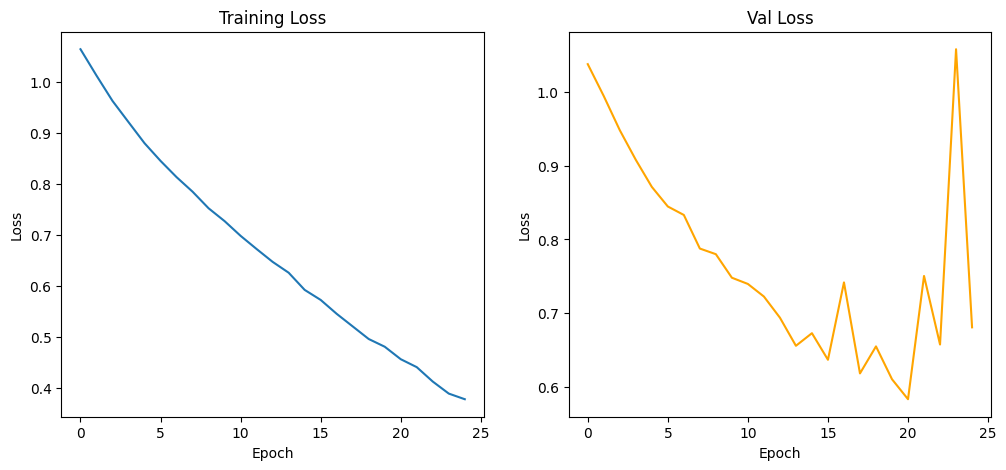

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

# **13. Đánh giá model:**

In [41]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.7623797648735304
Test accuracy:  0.758
